# Transfer Learning with MobileNetV2

In this project, we will use transfer learning on a pre-trained CNN to build an Alpaca/Not Alpaca classifier.


This project was done as part of the Coursera: Deep learning specialization

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

### Create the Dataset and Split it into Training and Validation Sets
we will use the `image_dataset_from_directory` function from the TensorFlow (tf.keras.preprocessing.image) library. This function is used to create an image dataset from a directory on disk. It is commonly used for tasks like image classification, where you have images stored in separate subdirectories based on their classes. 

In [35]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


let's take a look at some of the images from the training set.
Some of the lables are wrong which is fine

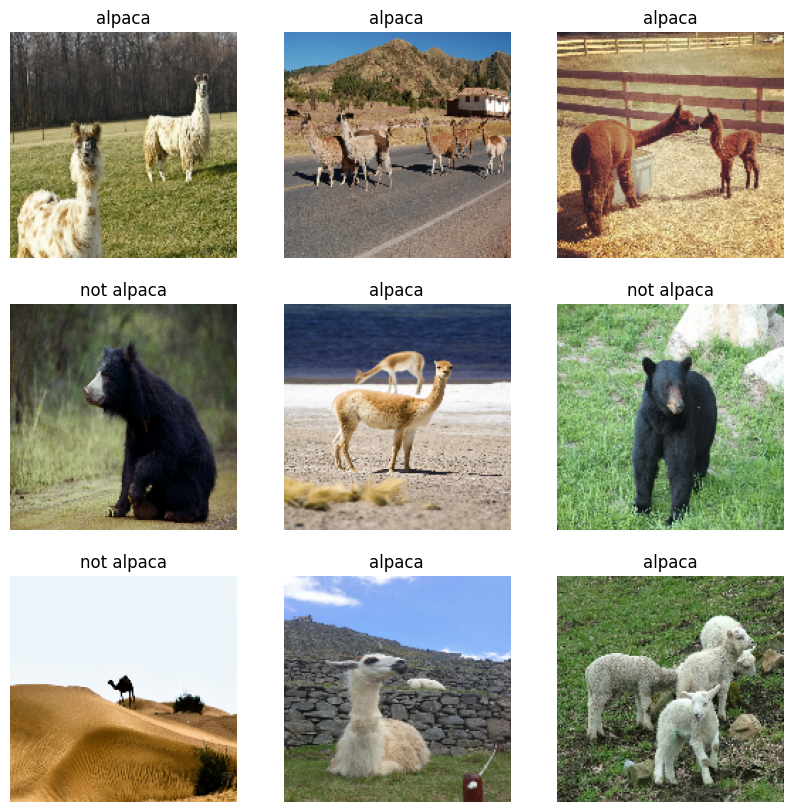

In [36]:
class_names = train_dataset.class_names  # returns the names of the classes: alpaca, not alpaca

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # take(1) takes one batch of pictures
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Preprocess and Augment Training Data

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

* The AUTOTUNE constant is used to enable dynamic, runtime-tuned performance. It allows TensorFlow to automatically adjust the buffer size for prefetching based on the available system resources and the execution environment. This can help improve the efficiency of data loading and training.
* The prefetch transformation is a technique used to optimize data loading during model training. When applied to the dataset, it allows data loading and preprocessing to happen asynchronously or in the background, separate from the model's execution. Instead of waiting for one batch to be fully processed before starting the next batch, TensorFlow begins fetching and preprocessing the next batch while the model is still training on the current batch. This is known as overlapping data loading and model execution.


### Data Augmentation
Data augmentation is transformations done on images that increase the diversity and size of the training dataset without collecting additional real-world data. By applying transformations like rotations, flips, translations, scaling, brightness adjustments, and more, data augmentation creates variations of the original data, making the model more robust and less prone to overfitting.

*Note:* Keras' Sequential API provides a convenient approach to implement such data augmentations, offering built-in and adaptable preprocessing layers. These layers are seamlessly integrated with your model, enabling easy saving and reusability for future applications.

In [38]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

Show some of the pictures after applying the transformation 

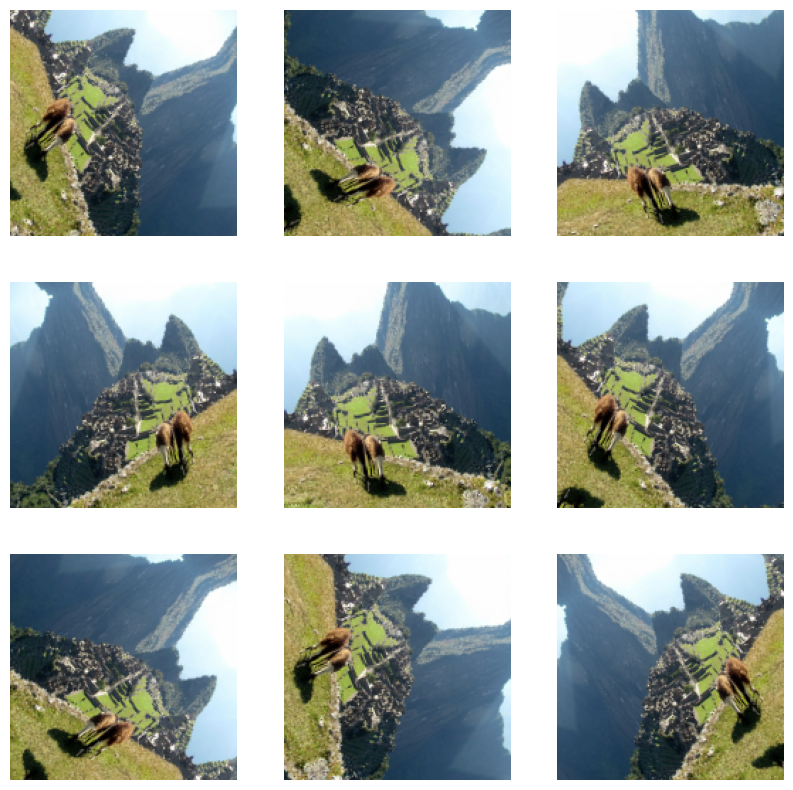

In [39]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[1]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## Import the pretrained MobileNetV2 model

The following is a function that performs preprocessing on input images to prepare them for the MobileNetV2 model.
It is a part of the MobileNetV2 model's specific preprocessing requirements, and it is used to ensure that the input images are in the correct format and range before being fed into the model for inference.

In [40]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Import the the model

In [41]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

Few things to explain about this function:
* The include_top parameter is a boolean that determines whether to include the top (classification) layers of the MobileNetV2 model. If set to True, the full pre-trained MobileNetV2 model with its classification layers will be loaded. If set to False, only the convolutional base of the model (excluding the classification layers) will be loaded. In this case, it is set to True, indicating that the fully pre-trained MobileNetV2 model with its classification layers will be used.
* The weights parameter specifies the weight initialization for the model. Setting weights='imagenet' means that the model will be initialized with pre-trained weights on the ImageNet dataset. Using pre-trained weights allows the model to start with good initial representations for many features, making it easier to fine-tune the model for other tasks.

We can look at the model summary and see that the last layer is indeed a prediction (classififcation) layer

In [42]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [43]:
nb_layers = len(base_model.layers)
print(f" Type of the last layer: {base_model.layers[nb_layers - 1].name}")

 Type of the last layer: predictions


We will get a batch of the training data and pass it through the model to see the results

In [44]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


Here there are 32 samples in the batch, and there are 1000 classes that the MobileNetV2 model was originaly trained on

In [45]:
# The lables of the 32 samples 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0])>

Now, we will pass the entire 32 examples to find the output
There are 32 results, each result consists of two classes with the highest probability.
Each output consistes of three values: First the class number, then a human-readable label, and last the probability of the image belonging to that class.

In [46]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n02489166', 'proboscis_monkey', 0.103300065),
  ('n02102177', 'Welsh_springer_spaniel', 0.078835875)],
 [('n02125311', 'cougar', 0.16546735), ('n02389026', 'sorrel', 0.10764287)],
 [('n02437312', 'Arabian_camel', 0.29232737),
  ('n02437616', 'llama', 0.2771354)],
 [('n03944341', 'pinwheel', 0.3115499), ('n03047690', 'clog', 0.052499894)],
 [('n02454379', 'armadillo', 0.7310718), ('n01990800', 'isopod', 0.03871983)],
 [('n02437312', 'Arabian_camel', 0.25663662),
  ('n02422106', 'hartebeest', 0.12122731)],
 [('n02437616', 'llama', 0.6612555),
  ('n02090721', 'Irish_wolfhound', 0.23782845)],
 [('n02133161', 'American_black_bear', 0.82735664),
  ('n02134418', 'sloth_bear', 0.02925942)],
 [('n01518878', 'ostrich', 0.9267561),
  ('n02002724', 'black_stork', 0.0017766347)],
 [('n01518878', 'ostrich', 0.949546), ('n02018795', 'bustard', 0.0028661555)],
 [('n02437616', 'llama', 0.8699825), ('n02412080', 'ram', 0.076757714)],
 [('n02415577', 'bighorn', 0.24294604), ('n02412080', 'ram', 0.160

We dont want thses classes so we will delete the top layer, which contains all the classification labels, and create a new classification layer.

## Layer Freezing with the Functional API

We will be using a pretrained model to modify the classifier task so that it's able to recognize alpacas. This will require three different steps:
* Delete the top layer
* Add a new classifier layer
* Freeze the base model and train the newly-created classifier layer 

In [47]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

Create the new model using the data_augmentation function defined earlier.

In [48]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

Compile the model

In [49]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train the new model for 5 epochs

In [50]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5


9/9 [==============================] - 7s 445ms/step - loss: 0.7259 - accuracy: 0.5954 - val_loss: 0.6348 - val_accuracy: 0.5538
Epoch 2/5
9/9 [==============================] - 3s 314ms/step - loss: 0.6190 - accuracy: 0.6565 - val_loss: 0.5162 - val_accuracy: 0.6154
Epoch 3/5
9/9 [==============================] - 3s 325ms/step - loss: 0.5428 - accuracy: 0.6870 - val_loss: 0.4789 - val_accuracy: 0.6308
Epoch 4/5
9/9 [==============================] - 3s 313ms/step - loss: 0.4504 - accuracy: 0.7405 - val_loss: 0.4161 - val_accuracy: 0.7077
Epoch 5/5
9/9 [==============================] - 3s 316ms/step - loss: 0.4186 - accuracy: 0.8015 - val_loss: 0.3566 - val_accuracy: 0.7538


plot the accuracy and the loss of the training and the validation set

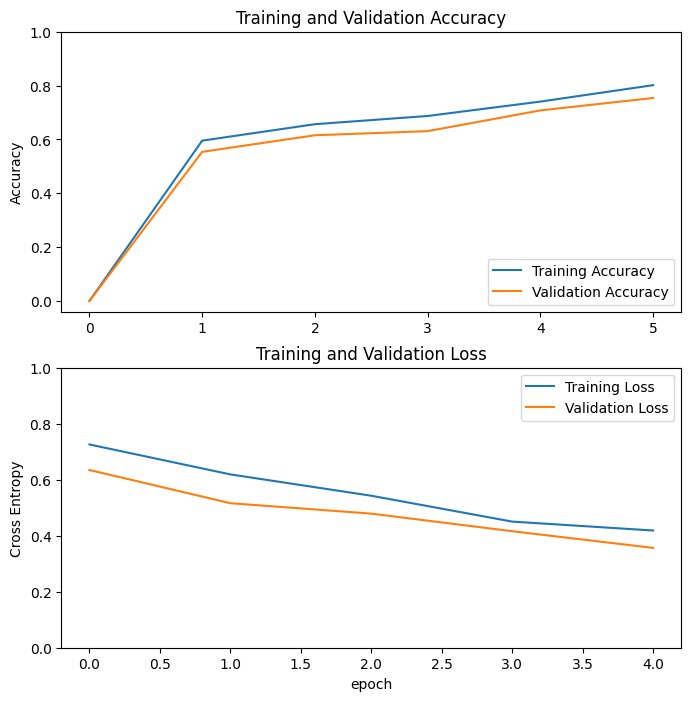

In [51]:
# get the accuracy of the training and validation set
# add 0 to start from 0.0 when we plot it 
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

# get the loss of the training and validation sets
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])  # makes the limit equal to 1 
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

This performance is good but we can do much better. We will use a method called `Fine tuning`. In this method, some of the weights are updated instead of just the last output layer.

## Fine Tuning 

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth.

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

First, let us count the number of layers in model 2, which is build by calling alpaca_model().

Input Layer:
<tensorflow.python.keras.engine.input_layer.InputLayer at 0x7fbc74251fd0> is the input layer of the model. It represents the input image and defines the shape of the input data.

Sequential Model:
<tensorflow.python.keras.engine.sequential.Sequential at 0x7fbcd4446a50> is a sequential model. It likely contains layers that are part of the new classification layers added on top of the base model. The exact details of these layers are not visible from this representation.

TensorFlowOpLayer:
<tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer at 0x7fbc3c15e1d0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer at 0x7fbc3c15c610> are TensorFlowOpLayer instances. These are internal TensorFlow layers that perform specific operations. The names of the layers are not visible from this representation.

Functional Model:
<tensorflow.python.keras.engine.functional.Functional at 0x7fbc180702d0> represents the base model (MobileNetV2) after it has been applied to the input data. It indicates that the MobileNetV2 model is being used as a functional model in this architecture.

GlobalAveragePooling2D Layer:
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D at 0x7fbbf87585d0> is the GlobalAveragePooling2D layer. It is applied after the base model and serves to summarize the information in each channel.

Dropout Layer:
<tensorflow.python.keras.layers.core.Dropout at 0x7fbbf87a1dd0> is the dropout layer. It is applied after the GlobalAveragePooling2D layer and helps prevent overfitting during training.

Dense (Prediction) Layer:
<tensorflow.python.keras.layers.core.Dense at 0x7fbbf86b5d50> is the dense layer responsible for the final prediction. It has one neuron with a linear activation function for binary classification.

In [52]:
model2.layers

The base model (functional model) however, has many layers

In [53]:
base_model = model2.layers[4]
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [54]:
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)

# Use accuracy as evaluation metric
metrics=['accuracy']

compile the model 

In [55]:
model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Fit the model

In [56]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10


9/9 [==============================] - 9s 488ms/step - loss: 0.6417 - accuracy: 0.7023 - val_loss: 0.2956 - val_accuracy: 0.9385
Epoch 6/10
9/9 [==============================] - 4s 407ms/step - loss: 0.3712 - accuracy: 0.8206 - val_loss: 0.1855 - val_accuracy: 0.9692
Epoch 7/10
9/9 [==============================] - 4s 408ms/step - loss: 0.2814 - accuracy: 0.8931 - val_loss: 0.1524 - val_accuracy: 0.9077
Epoch 8/10
9/9 [==============================] - 4s 400ms/step - loss: 0.2159 - accuracy: 0.9198 - val_loss: 0.1492 - val_accuracy: 0.8923
Epoch 9/10
9/9 [==============================] - 4s 399ms/step - loss: 0.1674 - accuracy: 0.9313 - val_loss: 0.1081 - val_accuracy: 0.9846
Epoch 10/10
9/9 [==============================] - 4s 396ms/step - loss: 0.1517 - accuracy: 0.9466 - val_loss: 0.1176 - val_accuracy: 0.9538


Get the accuracy and the loss

In [57]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plot the accuracy and loss

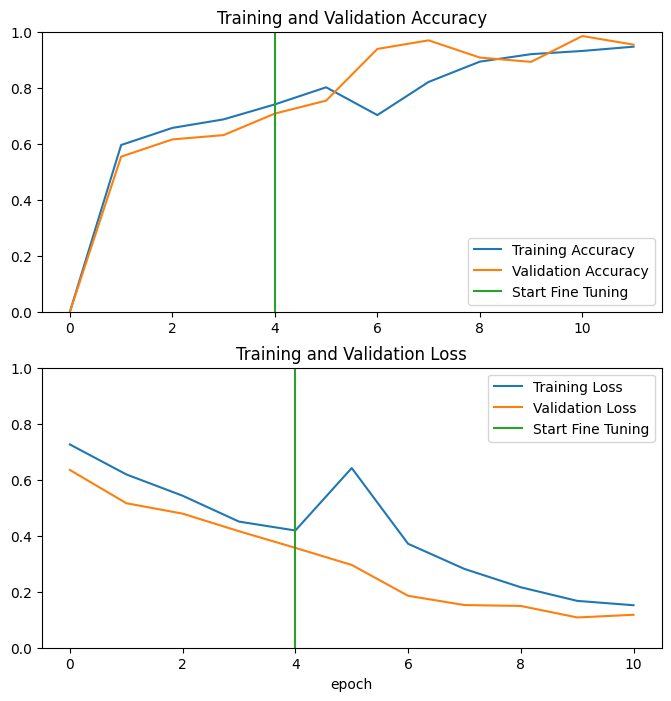

In [58]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning') # draw a vertical line where the first model stopped training
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning') # draw a vertical line where the first model stopped training
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 89.2% accuracy on the validation set